In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_df = pd.read_csv('/content/drive/MyDrive/YeniSeri/house-price-prediction/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/YeniSeri/house-price-prediction/test.csv')

#Set plot style
sns.set(style="whitegrid")
print("Train Shape:", train_df.shape)
train_df.head()


Train Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


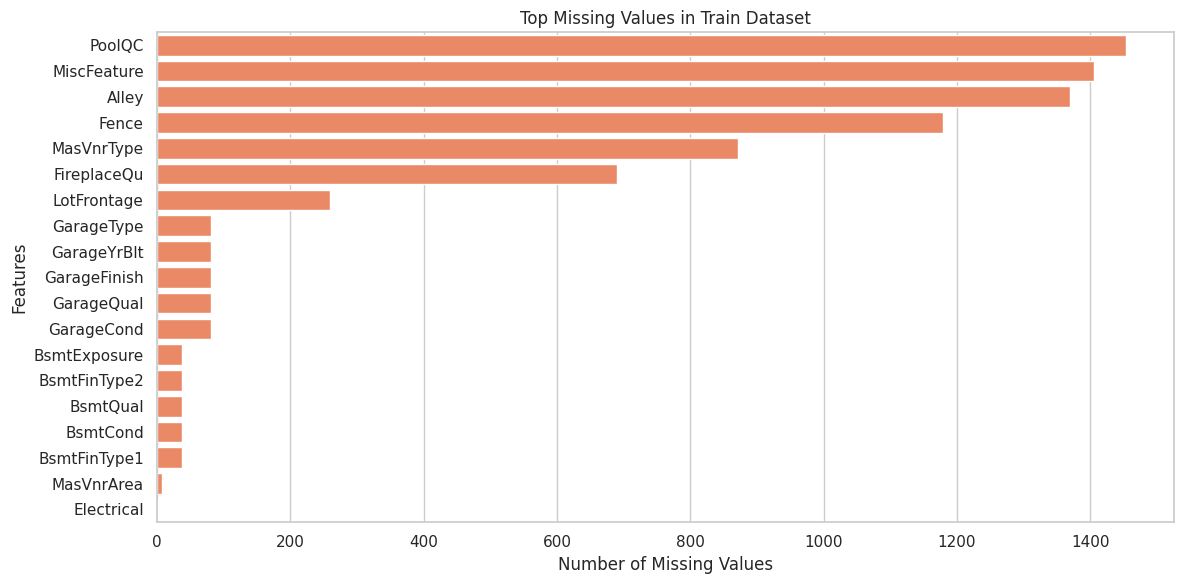

In [4]:
# Calculate missing values
missing = train_df.isnull().sum()
missing = missing[missing > 0] # Filter only features with missing values
missing.sort_values(ascending=False, inplace=True) # Sort in descending order

# Plotting the missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing.values, y=missing.index, color="coral")
plt.title("Top Missing Values in Train Dataset")
plt.xlabel("Number of Missing Values")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

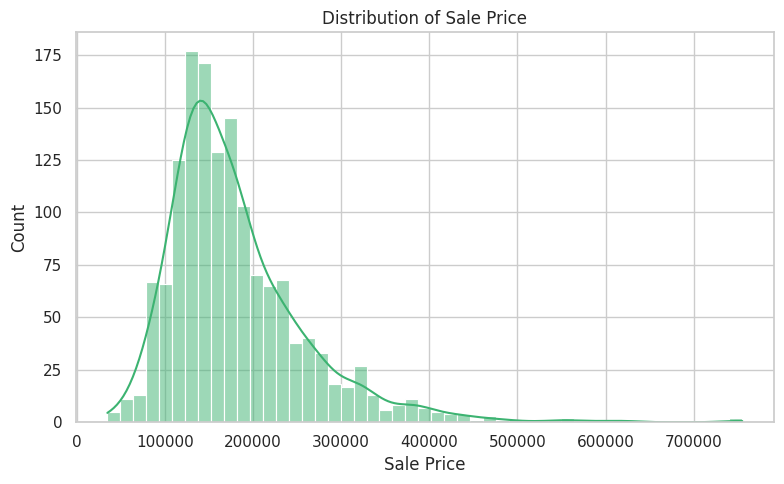

In [5]:
# Distribution of the target variable 'SalePrice'
plt.figure(figsize=(8, 5))
sns.histplot(train_df['SalePrice'], kde=True, color='mediumseagreen')
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Skewness after log transform: 0.121


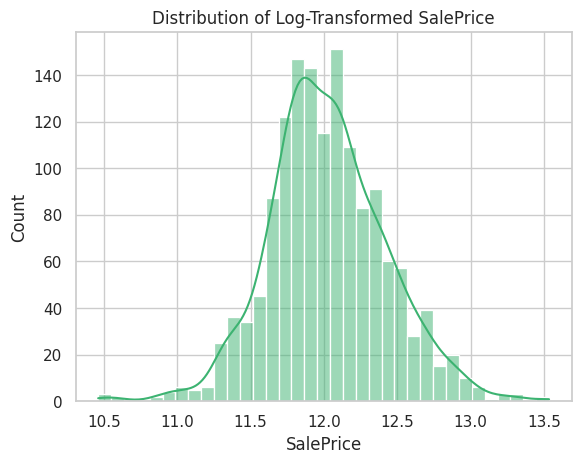

In [6]:
# Log transform SalePrice to reduce skewness
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# Skewness after transformation
print(f"Skewness after log transform: {train_df['SalePrice'].skew():.3f}")

# Histogram plot after transformation
sns.histplot(train_df['SalePrice'], kde=True, color='mediumseagreen')
plt.title('Distribution of Log-Transformed SalePrice')
plt.show()

In [7]:
# Compute correlation matrix (numeric features only)
corr_matrix = train_df.corr(numeric_only=True)

# Correlation with target variable 'SalePrice'
corr_with_target = corr_matrix['SalePrice'].sort_values(ascending=False)

# Show top 10 most correlated features
print(corr_with_target.head(11))  # SalePrice + en yüksek 10 özellik


SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
Name: SalePrice, dtype: float64


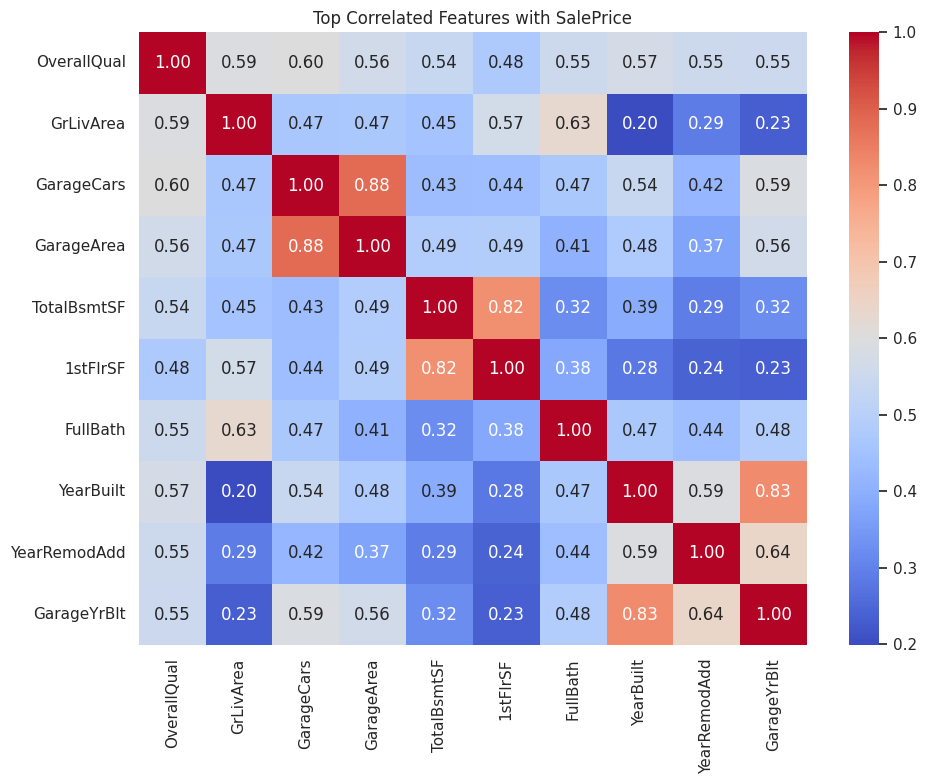

In [8]:
# Select the top correlated features (excluding SalePrice itself)
top_features = corr_with_target.index[1:11]  # SalePrice is first, skip it.

# Plot heatmap of these features
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Features with SalePrice")
plt.tight_layout()
plt.show()


In [9]:
#Check for missing values in the dataset
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


In [10]:
# Delete more than %80 missing
threshold = 0.8
missing_ratio = train_df.isnull().sum() / len(train_df)
cols_to_drop = missing_ratio[missing_ratio > threshold].index
train_df.drop(cols_to_drop, axis=1, inplace=True)

In [33]:
# Fill numerical columns with median
numerical_cols = train_df.select_dtypes(include=["int64", "float64"]).columns

for col in numerical_cols:
    if train_df[col].isnull().sum() > 0:
        # inplace=True yerine doğrudan atama yapıyoruz, böylece uyarı vermez
        train_df[col] = train_df[col].fillna(train_df[col].median())

In [34]:
# Fill categorical columns with "None" (Kategorik verilerdeki boşlukları doldurma)
categorical_cols = train_df.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    if train_df[col].isnull().sum() > 0:
        # inplace=True yerine atama yapıyoruz, böylece uyarı vermiyor
        train_df[col] = train_df[col].fillna("None")

In [35]:
train_df.isnull().sum().sort_values(ascending=False).head()


,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0


In [36]:
train_df_encoded = pd.get_dummies(train_df, drop_first=True)


In [37]:
from sklearn.model_selection import train_test_split

# Target variable: SalePrice
y = train_df_encoded['SalePrice']

# Feature matrix:
X = train_df_encoded.drop('SalePrice', axis=1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Fill missing numerical values with the median from the train set
for col in test_df.select_dtypes(include=["int64", "float64"]).columns:
    test_df[col] = test_df[col].fillna(train_df[col].median())

# Fill missing categorical values with "None"
for col in test_df.select_dtypes(include=["object"]).columns:
    test_df[col] = test_df[col].fillna("None")

# Apply One-Hot Encoding to test data
test_df_encoded = pd.get_dummies(test_df, drop_first=True)

#  Align test data columns with train data columns by adding missing columns with zeros
missing_cols = set(train_df_encoded.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0  # Add missing columns with zero values

# Reorder test data columns to match train data (except target column)
test_df_encoded = test_df_encoded[train_df_encoded.columns.drop('SalePrice')]


In [39]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [40]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_val_pred = lr_model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R2 Score: {r2:.4f}")


Validation RMSE: 0.2108
Validation R2 Score: 0.7618


In [41]:
test_predictions = lr_model.predict(test_df_encoded)


In [42]:
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_predictions
})

submission.to_csv("submission.csv", index=False)
print(submission.head())



     Id  SalePrice
0  1461   8.931638
1  1462   9.182649
2  1463   9.326562
3  1464   9.405782
4  1465   9.397719
